<a href="https://colab.research.google.com/github/pabloderen/BIMinferer/blob/master/Pipe_Analysis_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import json
import urllib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import numpy as np

import joblib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Download the Data

We download from de API in Flasgger (http://3.14.88.102:5000/apidocs/) the Pipe list item and it´s parameters


In [2]:
jsonfile = urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6500").read().decode()
j=json.loads(jsonfile)

Then we make a Data Frame with the json file

# Create the DataFrame

In [3]:
df= pd.json_normalize(j)
df.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Material Edition

we can see how many different materials we have, so then we will 
group by PVC, Copper and Steel

In [4]:
df["properties_Mechanical_Material"].unique()

array([nan, 'Copper', 'Steel, Carbon', '<By Category>',
       'Polyvinyl Chloride - Rigid', 'CP_PI - Copper - ASTM B88 H.D.',
       'CP_PI - Steel - ASTM A53-B', 'CP_PI - PVC', 'Cast Iron',
       'Black Steel', 'Carbon Steel', 'Ductile Iron',
       'Polyvinyl Chloride, Rigid', 'Carbon Steel - ASTM A53 B'],
      dtype=object)

To make such a grouping, we define a function that search in the "properties_Mechanical_Material" and change each row that has another different name for the same material

In [5]:
def search(data):
   
    if "A53" in data.upper():
        return "Carbon Steel - ASTM A53 B"
    if "CATEGORY" in data.upper():
        return "NaN"
    if "POLYVINYL" in data.upper():
        return "PVC"
    if "PVC" in data.upper():
        return "PVC"
    if "NAN" in data.upper():
        return "NaN"
    else:
        return data

For practical purpuses, we will make a copy of the DataFrame, 
then apply the function in each row of the "properties_Mechanical_Material" column.

In [6]:
df2=df
df2["properties_Mechanical_Material"]=df2["properties_Mechanical_Material"].apply(lambda x: search(str(x)))


here is the amount of each material kind

In [7]:

df2["properties_Mechanical_Material"].value_counts()


PVC                               1745
Carbon Steel                      1737
Carbon Steel - ASTM A53 B         1322
Copper                            1102
CP_PI - Copper - ASTM B88 H.D.     424
Steel, Carbon                      121
NaN                                 41
Black Steel                          4
Cast Iron                            2
Ductile Iron                         2
Name: properties_Mechanical_Material, dtype: int64

Here we can see a graphic of the different amount of each materials:

# Graphics

[Text(0, 0.5, 'Material')]

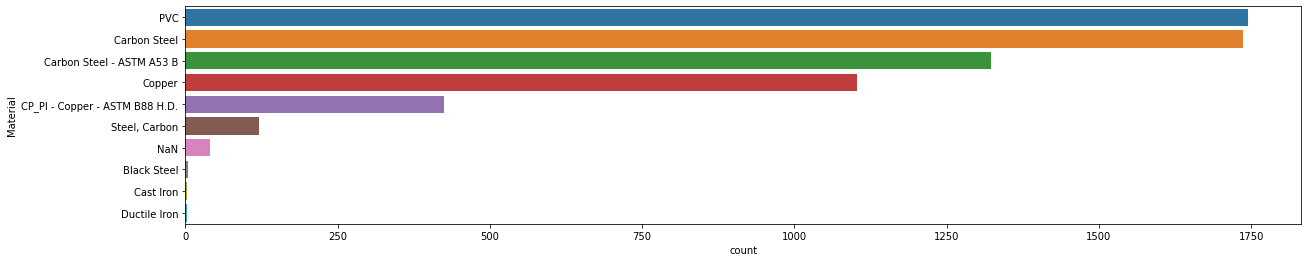

In [8]:

plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_Material",data=df2,order=df2["properties_Mechanical_Material"].value_counts().index)
ax.set( ylabel="Material")

In [9]:
df2["properties_Mechanical_System Classification"].value_counts()

Hydronic Supply        1668
Hydronic Return        1523
Sanitary               1499
Domestic Cold Water     730
Vent                    417
Domestic Hot Water      321
Other                   187
Fire Protection Dry     116
Fire Protection Wet       2
Name: properties_Mechanical_System Classification, dtype: int64

Here we have an graphic of the system

[Text(0, 0.5, 'System Classification')]

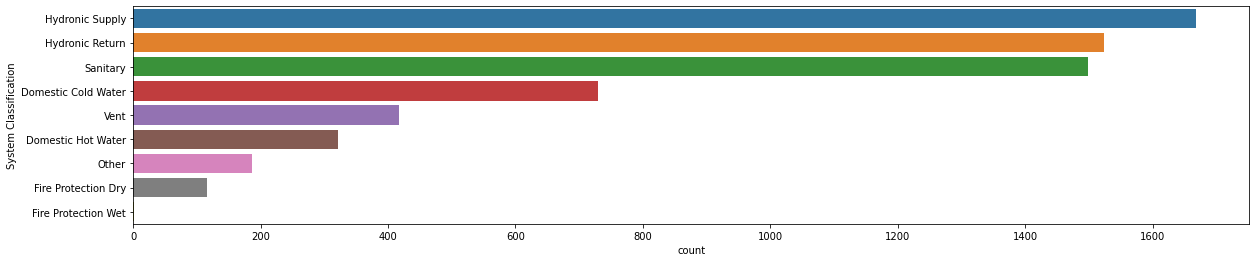

In [10]:
plt.figure(figsize=(20,4))
ax=sns.countplot(y="properties_Mechanical_System Classification",data=df2,order=df2["properties_Mechanical_System Classification"].value_counts().index)
ax.set( ylabel="System Classification")

# Length Edition

We drop the rows with properties_Dimensions_Length NaN values.

In [11]:
df3=df2.dropna(axis=0,subset=["properties_Dimensions_Length"])


Her we start to convert the properties_Dimensions_Length from string to float 
(we use x.replace(" ft","") and x.replace("  ft",""), notice the spaces in each case)



In [12]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace(" ft",""))
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: x.replace("  ft",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
df3["properties_Dimensions_Length"]= df3["properties_Dimensions_Length"].apply(lambda x: float(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Size Edition

we are analazing pipes, so we know that the dimensions Sizes are the diameter sizes. Then we can see that because a Size has the diameter simbol, creates another dimension. So we will take of the diameter simbol of all the column.

In [14]:
df3["properties_Dimensions_Size"].value_counts().head(5)

2"     643
4"ø    612
6"ø    549
4"     522
3"     436
Name: properties_Dimensions_Size, dtype: int64

In [15]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.replace("ø",""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Here we eliminate any leading and trailing whitespaces

In [16]:
df3["properties_Dimensions_Size"]= df3["properties_Dimensions_Size"].apply(lambda x: x.strip())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
df3["properties_Dimensions_Size"].value_counts()

4"        1152
2"         843
3/4"       745
6"         719
3"         704
1"         598
2 1/2"     340
1 1/2"     310
1 1/4"     309
1/2"       241
16"        146
14"         96
8"          88
12"         64
10"         60
5"          22
30"         22
36"          2
1 3/8"       2
Name: properties_Dimensions_Size, dtype: int64

[Text(0.5, 0, 'Dimensions Size')]

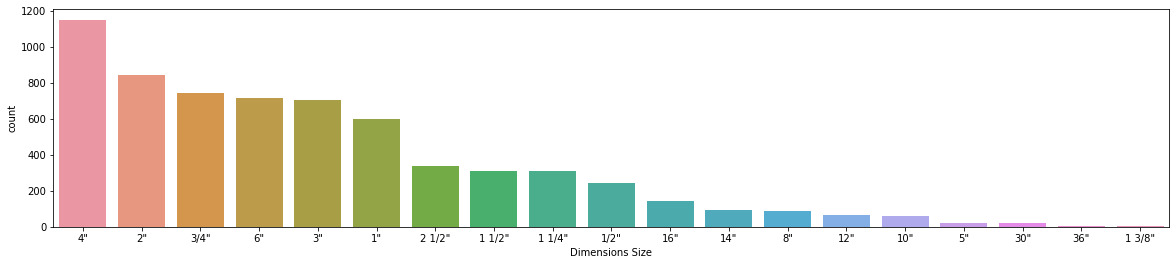

In [18]:
plt.figure(figsize=(20,4))
ax=sns.countplot(x="properties_Dimensions_Size",data=df3,order=df3["properties_Dimensions_Size"].value_counts().index)
ax.set( xlabel= "Dimensions Size")

In [58]:
df3["Size_F"]= df3["properties_Dimensions_Size"].apply(lambda x: x.replace('"',""))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))

In [60]:
df3["Size_F"]= df3["Size_F"].apply(lambda x: convert_to_float(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [72]:
df_3d=df3[["Size_F","properties_Dimensions_Length","properties_Mechanical_System Classification","properties_Mechanical_Material"]]
df_3d

,Size_F,properties_Dimensions_Length,properties_Mechanical_System Classification,properties_Mechanical_Material
2,2.5,0.398,Sanitary,Copper
4,2.5,2.536,Sanitary,"Steel, Carbon"
5,2.5,0.031,Sanitary,NaN
6,2.5,0.031,Sanitary,NaN
7,2.5,0.736,Other,"Steel, Carbon"
...,...,...,...,...
6495,3.0,4.218,Hydronic Return,Carbon Steel
6496,3.0,4.218,Hydronic Return,Carbon Steel
6497,3.0,1.078,Hydronic Return,Carbon Steel
6498,3.0,1.078,Hydronic Return,Carbon Steel


In [87]:
df2["properties_Mechanical_System Classification"].value_counts().index
Class_1={}
j=1
for i in df2["properties_Mechanical_System Classification"].value_counts().index:
  Class_1[i]=j
  j=j+1

In [88]:
Class_1

{'Domestic Cold Water': 4,
 'Domestic Hot Water': 6,
 'Fire Protection Dry': 8,
 'Fire Protection Wet': 9,
 'Hydronic Return': 2,
 'Hydronic Supply': 1,
 'Other': 7,
 'Sanitary': 3,
 'Vent': 5}

In [91]:
df_3d["Classification"]= df_3d["properties_Mechanical_System Classification"].apply(lambda x: Class_1[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
dicc
df_3d["Mate_n"]= df_3d["properties_Mechanical_Material"].apply(lambda x: dicc[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
df_3d["Size_F"].value_counts()

4.000     1152
2.000      843
0.750      745
6.000      719
3.000      704
1.000      598
2.500      340
1.500      310
1.250      309
0.500      241
16.000     146
14.000      96
8.000       88
12.000      64
10.000      60
30.000      22
5.000       22
1.375        2
36.000       2
Name: Size_F, dtype: int64

# 3DGraphic

Text(0.5, 0, 'Classification')

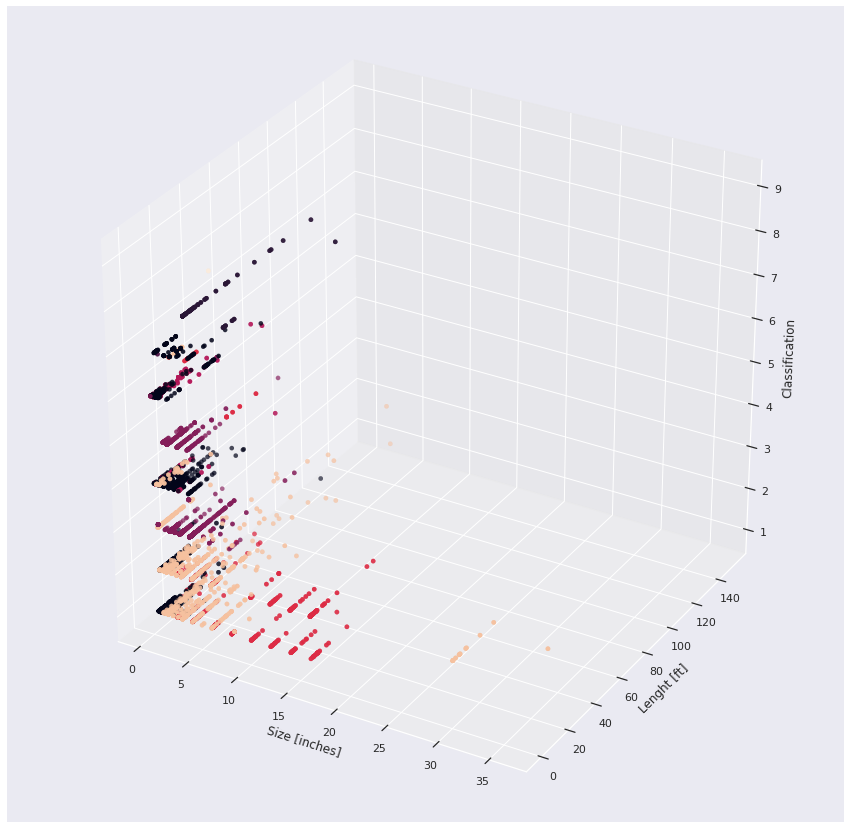

In [154]:
from mpl_toolkits.mplot3d import Axes3D
group=(1,2,3,4,5,6,7,8,9)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
cb=ax.scatter(df_3d.Size_F, df_3d.properties_Dimensions_Length, df_3d.Classification,c=df_3d.Mate_n, linewidth=0.1,label=group)
ax.set_xlabel('Size [inches]')
ax.set_ylabel('Lenght [ft]')
ax.set_zlabel('Classification')


In [117]:

df2["properties_Mechanical_Material"].value_counts()


PVC                               1745
Carbon Steel                      1737
Carbon Steel - ASTM A53 B         1322
Copper                            1102
CP_PI - Copper - ASTM B88 H.D.     424
Steel, Carbon                      121
NaN                                 41
Black Steel                          4
Cast Iron                            2
Ductile Iron                         2
Name: properties_Mechanical_Material, dtype: int64

# Enlist Materials

In [ ]:
g1=(df_3d["Size_F"])

The ""properties_Mechanical_Material" are 10 different types. Our target of inference will be the differents kinds of materials

In [62]:
 lista = df3["properties_Mechanical_Material"].unique()
lista

array(['Copper', 'Steel, Carbon', 'NaN', 'PVC',
       'CP_PI - Copper - ASTM B88 H.D.', 'Carbon Steel - ASTM A53 B',
       'Cast Iron', 'Black Steel', 'Carbon Steel', 'Ductile Iron'],
      dtype=object)

Set a number designator to all properties_Mechanical_System Classification

In [63]:
dicc={}
i=0
for i in range(0,10):
  dicc[lista[i]]=i

we create a column with this designation

In [64]:
df3["Material_Number"]=df3["properties_Mechanical_Material"].apply(lambda x: dicc[x])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Dummies Data

Then we get the dummies properties_Dimensions_Size and properties Mechanical System Classification

In [65]:
df3["properties_Dimensions_Size"].nunique()

19

In [66]:
classification= pd.get_dummies(df3["properties_Mechanical_System Classification"])


In [67]:
Dimensions_Size= pd.get_dummies(df3["properties_Dimensions_Size"])


In [68]:
df4 = pd.concat([df3,classification,Dimensions_Size],axis=1)

We eliminate some columns that we will not use 

In [69]:
droplist=["Category","properties_Mechanical_System Classification","properties_Mechanical_Material"
,"properties_Dimensions_Size", "projectId", "modelId","_id.$oid","Size_F"]
df5=df4.drop(droplist, axis=1)

In [70]:
df5.head(3).columns


Index(['properties_Dimensions_Length', 'Material_Number',
       'Domestic Cold Water', 'Domestic Hot Water', 'Fire Protection Dry',
       'Fire Protection Wet', 'Hydronic Return', 'Hydronic Supply', 'Other',
       'Sanitary', 'Vent', '1 1/2"', '1 1/4"', '1 3/8"', '1"', '1/2"', '10"',
       '12"', '14"', '16"', '2 1/2"', '2"', '3"', '3/4"', '30"', '36"', '4"',
       '5"', '6"', '8"'],
      dtype='object')

# Train Test Split

Here we define the size of our test size. We will use a 30% of the download data

In [28]:
X = df5.drop('Material_Number',axis=1)
y = df5['Material_Number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

# Model Fit

 Here we train our Random Forest

In [29]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

# Predictions

In [30]:

predictions = rfc.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.94      0.83      0.88       115
           1       1.00      1.00      1.00        18
           3       0.99      1.00      1.00       175
           4       0.71      0.89      0.79        38
           5       0.97      0.97      0.97       130
           8       0.94      0.96      0.95       171

    accuracy                           0.95       647
   macro avg       0.93      0.94      0.93       647
weighted avg       0.95      0.95      0.95       647



# Dispersion Analysis

Here we compare the Mean Absolute error of the inferences made with and without consider the lenghts of the pipes.

-With Pipe Lengths MAE= 0.23

-Without Pipe Lengths MAE= 0.69

So we note that the lengths give us more dispersion, and we will take off from the inference

In [31]:
score = mean_absolute_error(y_test,predictions)
print('MAE:', score)

MAE: 0.25193199381761977


# Sección nueva

In [32]:
dicc

{'Black Steel': 7,
 'CP_PI - Copper - ASTM B88 H.D.': 4,
 'Carbon Steel': 8,
 'Carbon Steel - ASTM A53 B': 5,
 'Cast Iron': 6,
 'Copper': 0,
 'Ductile Iron': 9,
 'NaN': 2,
 'PVC': 3,
 'Steel, Carbon': 1}

# Download the Data (second part)

In [33]:

jsonfile2= urllib.request.urlopen("http://3.14.88.102:5000/api/1/elements/pipes/?limit=6500").read().decode()
j2=json.loads(jsonfile2)

In [34]:
dataf= pd.json_normalize(j2)
dataf.head(3)

,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
0,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a82,NaN,NaN,NaN,NaN
1,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a83,NaN,NaN,NaN,NaN
2,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee8651cb573f2fc2216a84,0.398 ft,"2 1/2""",Copper,Sanitary


# Data to Infer

For a given Item, we infer what material it could be. In this case we toke the 100th elemnt

In [35]:
eli=dataf.iloc[55].to_frame().T
#First individualizate the elemnt
eli


,projectId,Category,modelId,_id.$oid,properties_Dimensions_Length,properties_Dimensions_Size,properties_Mechanical_Material,properties_Mechanical_System Classification
55,b.c94f85e5-88fb-402c-bc60-72622f5f85b6,Pipes,d4ea3308-4b3f-d382-cacb-9791f772042b,5eee866fcb573f2fc2216e51,0.050 ft,"2""",Polyvinyl Chloride - Rigid,Sanitary


here we make a dictionary with the size, classification and Length elements

In [36]:

def search_title(var):
  i=0
  values={}

  Ele=var.iloc[0].index.nunique()
  for i in range(0,Ele):
    value=var.iloc[0].index[i].upper()
    if "SIZE" in value:
        values["Size"]=var.iloc[0][i]

    if "CLASSIFICATION" in value:
        values["Classification"]=var.iloc[0][i]

    if "LENGTH" in value:
        values["Length"]=var.iloc[0][i]
  return values

item=search_title(eli)
item


{'Classification': 'Sanitary', 'Length': '0.050 ft', 'Size': '2"'}

Edit the Size format

In [37]:
item["Size"]=item["Size"].replace("ø","")
item["Size"]=item["Size"].strip()
item["Size"]

'2"'

Edit the Lenght format

In [38]:
item["Length"]=item["Length"].replace(" ft","")
item["Length"]=item["Length"].replace("  ft","")
item["Length"]
item["Length"]

'0.050'

In [39]:
pro=df5.columns.to_frame(index=True).T
pro.drop(labels=0,axis=0,inplace=True)

In [40]:
#this list is just for make the new_row dictionary 
items=[item["Classification"],item["Size"]]

new_row={}

for i in pro.columns:
  if i == "properties_Dimensions_Length":
    new_row[i]=float(item["Length"])
  elif i in items:
    new_row[i]=1
  else:
      new_row[i]=0


In [41]:
new_row

{'1 1/2"': 0,
 '1 1/4"': 0,
 '1 3/8"': 0,
 '1"': 0,
 '1/2"': 0,
 '10"': 0,
 '12"': 0,
 '14"': 0,
 '16"': 0,
 '2 1/2"': 0,
 '2"': 1,
 '3"': 0,
 '3/4"': 0,
 '30"': 0,
 '36"': 0,
 '4"': 0,
 '5"': 0,
 '6"': 0,
 '8"': 0,
 'Domestic Cold Water': 0,
 'Domestic Hot Water': 0,
 'Fire Protection Dry': 0,
 'Fire Protection Wet': 0,
 'Hydronic Return': 0,
 'Hydronic Supply': 0,
 'Material_Number': 0,
 'Other': 0,
 'Sanitary': 1,
 'Vent': 0,
 'properties_Dimensions_Length': 0.05}

This is the one row DataFrame that we will use to test the model to predict

In [42]:
k=pro.append(new_row, ignore_index=True)

In [43]:
X_infer = k.drop('Material_Number',axis=1)
y_infer = pro['Material_Number']

In [44]:
predictions = rfc.predict(X_infer)
int(predictions)

3

Recalling the dictionary we made, we change key for value and vice versa

In [105]:
dicc

{'Black Steel': 7,
 'CP_PI - Copper - ASTM B88 H.D.': 4,
 'Carbon Steel': 8,
 'Carbon Steel - ASTM A53 B': 5,
 'Cast Iron': 6,
 'Copper': 0,
 'Ductile Iron': 9,
 'NaN': 2,
 'PVC': 3,
 'Steel, Carbon': 1}

In [46]:
dicc2={}

for i in dicc.keys():
  dicc2[dicc[i]]=i
dicc2


{0: 'Copper',
 1: 'Steel, Carbon',
 2: 'NaN',
 3: 'PVC',
 4: 'CP_PI - Copper - ASTM B88 H.D.',
 5: 'Carbon Steel - ASTM A53 B',
 6: 'Cast Iron',
 7: 'Black Steel',
 8: 'Carbon Steel',
 9: 'Ductile Iron'}

# Result of a determined prediction

In [47]:
dicc2[int(predictions)]

'PVC'

recalling, eli is the element of that we want to infer wich material it is

In [48]:
eli.iloc[0][6]

'Polyvinyl Chloride - Rigid'

# Prediction Model Download

In [49]:
import dill

In [50]:
wd = "Users\bdere\Desktop\computer\haha"

In [51]:
dill.dump(rfc, open(wd + "PipeAnalysis.sav","wb"))

In [52]:
with open(wd + "PipeAnalysis.sav","wb") as f:
    dill.dump(rfc,f)

In [53]:
model = dill.load(open(wd + "PipeAnalysis.sav","rb"))

In [54]:
predic=model.predict(X_infer)
int(predic)

3